---
title: Linear Convection
suptitle: Linear Convection with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [35]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# defime some variables
nx = 81
nt = 25
c = 1.0
dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)

sigma = 0.2
dt = sigma * dx
dx, d

In [28]:
# initialize field to be zero
u = 2 * jnp.ones((nx, ny))

In [29]:
u.shape

(81, 81)

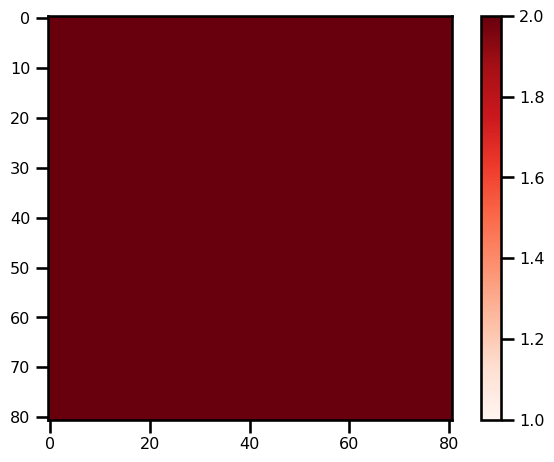

In [30]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds", vmin=1.0, vmax=2.0)
plt.colorbar(pts)
plt.tight_layout()
plt.show()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [33]:
# initialize field to be constant
u = 2 * np.ones((nx, ny))

for t in trange(nt + 1):
    # copy to avoid overwriting
    un = u.copy()

    # apply boundary conditions
    u[0, :] = 1.0  # left
    u[-1, :] = 1.0  # right
    u[:, 0] = 1.0  # bottom
    u[:, -1] = 1.0  # top

    # calculate the terms
    t1 = un[1:, 1:]
    t2 = -c * (dt / dy) * (un[1:, 1:] - un[1:, :-1])
    t3 = -c * (dt / dx) * (un[1:, 1:] - un[:-1, 1:])

    u[1:, 1:] = t1 + t2 + t3


# small sanity check
assert (u[45:55, 45:55] > 1.8).all()

  0%|          | 0/101 [00:00<?, ?it/s]

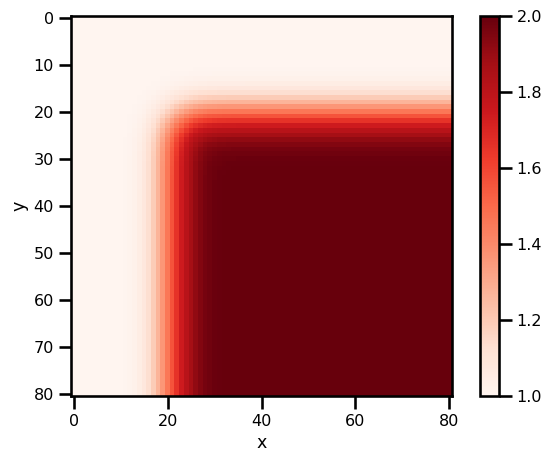

In [34]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds", vmin=1.0, vmax=2.0)
ax.set(xlabel="x", ylabel="y")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Refactor: Jax Syntax

**Add the Jax Syntax**. So there are some common gotcha's in JAX. The main ones I always have include the inplace operations and the while loops. In this case, we need to convert this gotch into

**Problems**:

* Add the jax syntax
* Everything is a function!

In [201]:
# defime some variables
nx = 81
ny = 81
nt = 100
c = 1.0
dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)

sigma = 0.2
dt = sigma * dx

### Function-ify Everything

There are at least a few functions that we can define:


* Boundary Conditions
* Finite Difference Operators (Forward, Backwards)
* Right-Hand Side
* Euler Step
* Step - Euler, RHS, BCs

#### Boundary Conditions

In [195]:
def bcs(u):
    # apply boundary conditions
    u = u.at[0, :].set(1.0)  # left
    u = u.at[-1, :].set(1.0)  # right
    u = u.at[:, 0].set(1.0)  # bottom
    u = u.at[:, -1].set(1.0)  # top

    return u

#### Finite Difference Operators


In [198]:
from jaxtyping import Array, Float

### RHS

So let's rewrite the PDE only looking at the spatial discretization.

```{math}
:label: discretization_spatial
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) - c \frac{1}{\Delta y}\left( u_{i,j}-u_{i,j-1}^n \right)
```

Notice that the spatial derivatives are *universal* in the sense that these operations are agnostic to the scalar field. So these can easily be made into simple functions.

```{math}
:label: forward_diff
\begin{aligned}
\text{fd}_x &:= \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) \\
\text{fd}_y &:= \frac{1}{\Delta y}\left( u_{i,j}-u_{i,j-1}^n \right)
\end{aligned}
```

In [202]:
def fd_2d_x(u: Float[Array, "Nx Ny"], dx: float) -> Float[Array, "Nx Ny"]:
    return (u[1:, 1:] - u[:-1, 1:]) / dx


def fd_2d_y(u: Float[Array, "Nx Ny"], dy: float) -> Float[Array, "Nx Ny"]:
    return (u[1:, 1:] - u[1:, :-1]) / dy

In [204]:
# initialize field to be constant
u = 2 * jnp.ones((nx, ny))

du_dx = fd_2d_x(u, dx)
u.shape, du_dx.shape

((81, 81), (80, 80))

In [ ]:
def rhs_lc(u, dx, dy, c):
    t1 = c * forward_difference_x(u, dx)
    t2 = c * forward_difference_y(u, dy)

    return -(t2 + t3)

In [146]:
from functools import partial


# def forward_difference_x(u, dx, ):
#     return sk.fd.difference(u, axis=0, step_size=dx, accuracy=1)


def rhs(u, dx, dy, c):
    t2 = c * forward_difference_x(u, dx)
    t3 = c * forward_difference_y(u, dy)

    return -(t2 + t3)


def euler_step(u, dt, rhs):
    return u[1:, 1:] + dt * rhs(u)


rhs_fn = partial(rhs, dx=dx, dy=dy, c=c)


def step(u):
    # euler step
    un = euler_step(u, dt=dt, rhs=rhs_fn)

    # apply boundaries
    u = bcs(u)

    # update
    u = u.at[1:, 1:].set(un)

    return u


step_fn = jax.jit(step)

In [147]:
# initialize field to be constant
u = 2 * jnp.ones((nx, ny))
debug = True

if debug:
    f = step
else:
    f = step_fn
for t in trange(nt + 1):
    # copy to avoid overwriting
    u = f(u)


# small sanity check
assert (u[45:55, 45:55] > 1.8).all()

u_final = u.copy()

  0%|          | 0/101 [00:00<?, ?it/s]

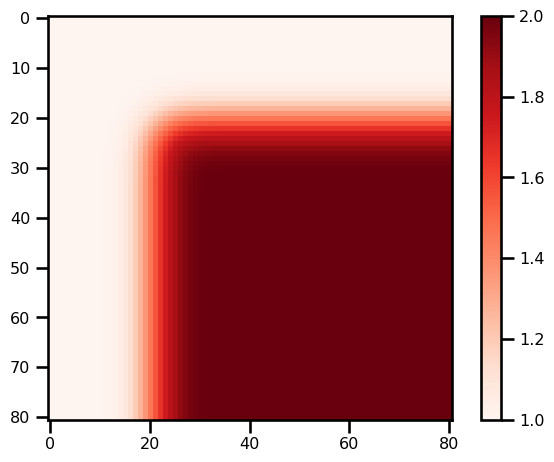

In [148]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Refactor: Derivatives

In [193]:
from jaxdf.operators.differential import derivative, gradient
import serket as sk

# def rhs_jaxdf(u):

#     du = gradient(u)
#     print(du.params.shape)
#     du_dx = du.replace_params(du.params[..., 0])
#     du_dy = du.replace_params(du.params[..., 1])
#     return -c * du_dx - c * du_dy


def forward_difference_x(u, dy):
    return (u[1:, 1:] - u[1:, :-1]) / dy


def forward_difference_y(u, dx):
    return (u[1:, 1:] - u[:-1, 1:]) / dx


def rhs_jaxdf(u):
    du_dx = sk.fd.difference(u.params, axis=0, step_size=dx, accuracy=1)
    du_dy = sk.fd.difference(u.params, axis=1, step_size=dy, accuracy=1)

    u = u.replace_params(-c * du_dx - c * du_dy)

    return u

In [191]:
methods = dict()


# ===============
# JAX
# ===============
def forward_difference_y(u, dy):
    return (u[1:, 1:] - u[1:, :-1]) / dy


def forward_difference_x(u, dx):
    return (u[1:, 1:] - u[:-1, 1:]) / dx


# initialize field to be constant
u_jnp = 2 * jnp.ones((nx, ny))
u_jnp = u_final.copy()

# calculate spatial derivatives
methods["du_dx_jax"] = forward_difference_x(u_jnp, dx)
methods["du_dy_jax"] = forward_difference_y(u_jnp, dy)

# ===============
# Serket
# ===============
methods["du_dx_serket"] = sk.fd.difference(u_jnp, axis=0, step_size=dx, accuracy=1)
methods["du_dy_serket"] = sk.fd.difference(u_jnp, axis=1, step_size=dy, accuracy=1)

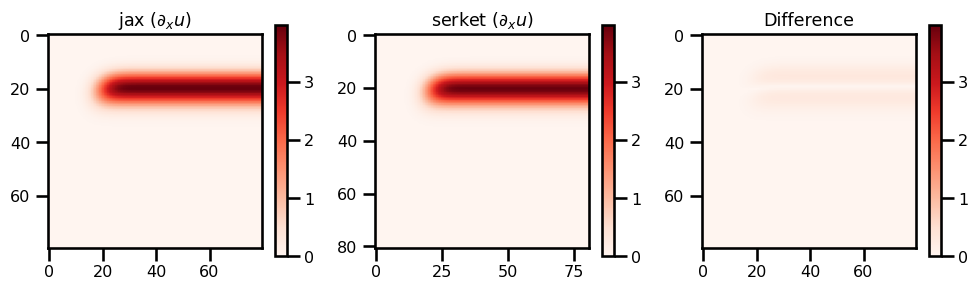

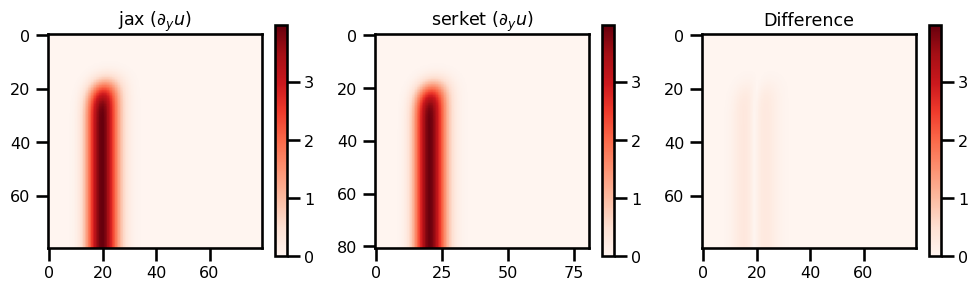

In [192]:
vmin = np.minimum(methods["du_dx_jax"].min(), methods["du_dx_serket"].min())
vmax = np.maximum(methods["du_dx_jax"].max(), methods["du_dx_serket"].max())

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
pts = ax[0].imshow(methods["du_dx_jax"], cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar(pts, shrink=0.5)
ax[0].set(title="jax ($\partial_x u$)")
pts = ax[1].imshow(methods["du_dx_serket"], cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar(pts, shrink=0.5)
ax[1].set(title=r"serket ($\partial_x u$)")
pts = ax[2].imshow(
    np.abs(methods["du_dx_serket"][1:, 1:] - methods["du_dx_jax"]),
    cmap="Reds",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar(pts, shrink=0.5)
ax[2].set(title=r"Difference")
plt.tight_layout()
plt.show()

vmin = np.minimum(methods["du_dy_jax"].min(), methods["du_dy_serket"].min())
vmax = np.maximum(methods["du_dy_jax"].max(), methods["du_dy_serket"].max())

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
pts = ax[0].imshow(methods["du_dy_jax"], cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar(pts, shrink=0.5)
ax[0].set(title="jax ($\partial_y u$)")
pts = ax[1].imshow(methods["du_dy_serket"], cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar(pts, shrink=0.5)
ax[1].set(title=r"serket ($\partial_y u$)")
pts = ax[2].imshow(
    np.abs(methods["du_dy_serket"][1:, 1:] - methods["du_dy_jax"]),
    cmap="Reds",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar(pts, shrink=0.5)
ax[2].set(title=r"Difference")
plt.tight_layout()
plt.show()

## Refactor!

So right away, we are going to start to refactor our solver to be more generalized. Below, I have outlined a few things that could possibly be refactored "easily".

* Objects (domain, field)
* Operators (derivatives)
* Boundary Conditions
* Time stepper! 

## Domain

We have a given set of coordinates for a 2D Euclidean space.

```{math}
:label: coordinates
\mathbf{x}\in\mathbb{R}^{D_s}
```

However, we need to define a spatial domain which is bounded.

```{math}
:label: domain
\mathbf{x}\in\Omega\sub\mathbb{R}^{D_s}
```

Practically speaking, this is a vector. However, we never actually have to store the vector; just the boundaries and the discretization.

In [149]:
# from jaxsw._src.domain.base import Domain
from jaxdf.geometry import Domain

In [150]:
# defime some variables
nx = 81
ny = 81
c = 1.0
dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)

# initialize domain class
domain = Domain(N=(nx, ny), dx=(dx, dy))

# some checks!
assert domain.ndim == 2
assert len(domain.size) == domain.ndim
assert len(domain.spatial_axis) == 2
assert domain.grid.shape == (nx, ny, domain.ndim)

## Field

Here we have the definition of a field.

```{math}
:label: field
u = \boldsymbol{u}(\mathbf{x}) \hspace{10mm} \boldsymbol{u}: \Omega\rightarrow\mathbb{R}^{D_u}\hspace{5mm} \mathbf{x}\in\Omega
```

Technically, the {eq}`field` described is a function that maps the coordinates {eq}`coordinates` defined within the discretized {eq}`domain`.

Practically speaking, a field, $u$, is an object with the scalar/vector values at each of the coordinate locations $\mathbf{x}$ in the domain $\Omega$. 

### Step 1: Initialize Field

In [31]:
from jaxdf.discretization import FiniteDifferences

# initialize field to be constant
u_np = 2 * jnp.ones((nx, ny))

# define input
init_u = 2 * jnp.ones((nx, ny))
u_jnp = FiniteDifferences.from_grid(grid_values=init_u, domain=domain)

# compute difference
u_diff = u_np - u_jnp.params.squeeze()
np.testing.assert_array_equal(u_np, u_jnp.params.squeeze())

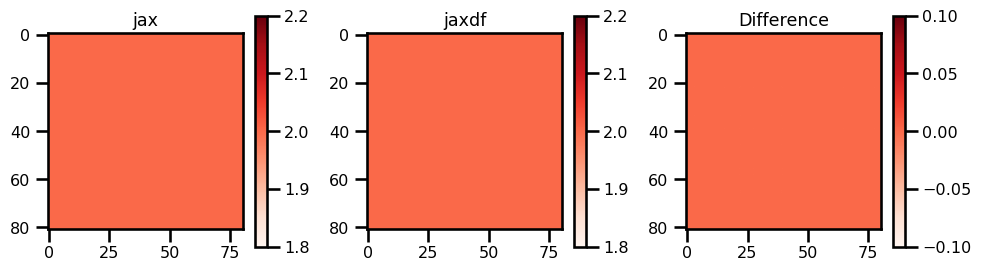

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
pts = ax[0].imshow(u_np, cmap="Reds")
plt.colorbar(pts, shrink=0.5)
ax[0].set(title="jax")
pts = ax[1].imshow(u_jnp.params, cmap="Reds")
plt.colorbar(pts, shrink=0.5)
ax[1].set(title="jaxdf")
pts = ax[2].imshow(u_diff, cmap="Reds")
ax[2].set(title="Difference")
plt.colorbar(pts, shrink=0.5)
plt.tight_layout()
plt.show()

So a field is a new object that has a set of operations. For example we can add, multiply, subtract and divide by other fields. We can also do a negative value and powers. Because of the custom definition of `field`, it is designed to only do the operations on the internal values, i.e. `field.values`.

In [20]:
# addition
u2 = u + u

np.testing.assert_equal(u2.params.min().item(), 4.0)
np.testing.assert_equal(u2.params.max().item(), 4.0)

# power
u2 = u**3

np.testing.assert_equal(u2.params.min().item(), 8.0)
np.testing.assert_equal(u2.params.max().item(), 8.0)

## Operators

Now, we want to use some of the differential operators available. In the above example, we immediately chose the spatial and temporal discretization to give us a bit of a nasty PDE. Using this package, we want to look at the two discretizations separately. In fact, we will only be paying attention to the spatial discretization using the `operators` available in this package.

So let's rewrite the PDE only looking at the spatial discretization.

$$
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) - c \frac{1}{\Delta y}\left( u_{i,j}-u_{i,j-1}^n \right)
$$


Sources:

* [Docs](https://ucl-bug.github.io/jaxdf/notebooks/quickstart/#more-complex-operators)
* [Diffrax Example](https://docs.kidger.site/diffrax/examples/nonlinear_heat_pde/)

### Step 2: Partial Derivatives

### Step 2: Boundary Conditions

In [93]:
# initialize field to be constant
u_jnp = 2 * jnp.ones((nx, ny))

# apply boundary conditions
u_jnp = bcs

In [94]:
from jaxdf.operators.differential import derivative, gradient

c = 2.0


def bcs(u):
    """Boundary Conditions"""

    # extract params
    u_vals = u.params

    # apply BCs
    u_vals = u_vals.at[0, :].set(1.0)  # left
    u_vals = u_vals.at[-1, :].set(1.0)  # right
    u_vals = u_vals.at[:, 0].set(1.0)  # bottom
    u_vals = u_vals.at[:, -1].set(1.0)  # top

    # replace params
    u = u.replace_params(u_vals)

    return u


def rhs(u):
    # apply boundary conditions
    u_bc = bcs(u)

    # apply spatial operators for RHS

    return u_bc

    # du = gradient(u)
    # du_dx = du.replace_params(du.params[..., 0])
    # du_dy = du.replace_params(du.params[..., 1])
    # return -c * du_dx - c * du_dy


# define input
init_u = 2 * jnp.ones((nx, ny))
u_jaxdf = FiniteDifferences.from_grid(grid_values=init_u, domain=domain)

u_jaxdf = rhs(u_jaxdf)

In [95]:
# compute difference
u_diff = u_jnp - u_jaxdf.params.squeeze()
np.testing.assert_array_equal(u_jnp, u_jaxdf.params.squeeze())

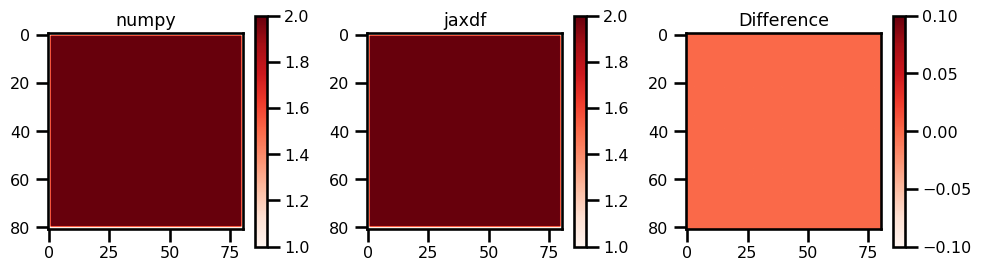

In [96]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
pts = ax[0].imshow(u_jnp, cmap="Reds")
plt.colorbar(pts, shrink=0.5)
ax[0].set(title="numpy")
pts = ax[1].imshow(u_jaxdf.params, cmap="Reds")
plt.colorbar(pts, shrink=0.5)
ax[1].set(title="jaxdf")
pts = ax[2].imshow(u_diff, cmap="Reds")
ax[2].set(title="Difference")
plt.colorbar(pts, shrink=0.5)
plt.tight_layout()
plt.show()

In [33]:
# define input
init_u = 2 * jnp.ones((nx, ny))
u = FiniteDifferences.from_grid(grid_values=init_u, domain=domain)

z = rhs(u)

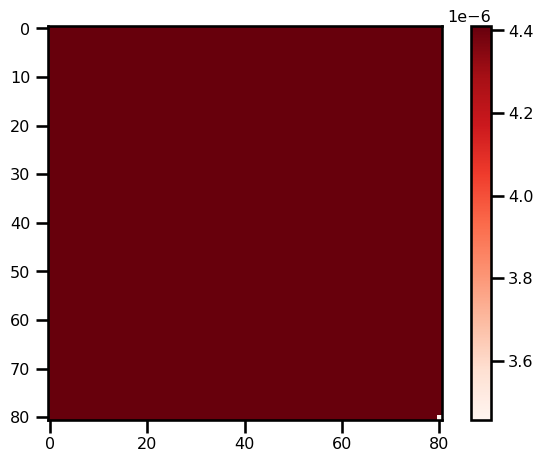

In [34]:
fig, ax = plt.subplots()
pts = ax.imshow(z.params[..., :], cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()